# Run benchmark with different variables to find combination which could lead to optimal ingestion performance
When ingesting data to OpenSearch using bulk API, using different variables could result in different ingestion performance. For example, the amount of document in bulk API, how many OpenSearch clients are used to send requests etc. It's not easy for user to experiment with all the combinations of the variables and find the option which could lead to optimal ingestion performance. In OpenSearch-2.15.0, a new parameter "batch size" was introduced in bulk API which could significantly reduce ingestion time when using with `text_embedding` processor and `sparse_encoding` processor. However, this additional impactor could make the variable tuning even more difficult.

This tool is to help dealing with the pain point of tuning these variables which could impact ingestion performance and automatically find the optimal combination of the variables. It utilizes the OpenSearch-Benchmark, uses different varible combination to run benchmark, collects their outputs, analyzes and visualizes the results.

There are three variables that you can test against: bulk size, OS client number, batch size. If you already have a perferred value for certain variable, you can simply set it to a fixed value and only test other variables. For example, you always use 1 client to run bulk API with bulk size equals to 100, then you can only try different batch size to see which batch size can have the best performance.

## Step 1: Import Packages

In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, "../")

from main import run_command, construct_parser

## Step 2: Prepare for test inputs
### Variable Test Schedule
All three variables have two different parameters, one to set fixed value and one to set a testing schedule. The schedule has two patterns:
1. set starting value, end value, step size and trend, separated by `:`, e.g. "10:100:1:10" means we should test with "10, 20, 30, 40, 50, 60, 70, 80, 90, 100". "20:100:-1:20" means we should test reversely with "100, 80, 60, 40, 20"。
2. configure testing values manually by adding a prefix symbol `@` and still separate values using `:` e.g. "@10:20:50" means we only test with 10, 20, 50.

Use `BULK_SIZE` to set a fixed bulk size value, e.g. `BULK_SIZE=100`
Use `BULK_SIZE_SCHEDULE` to set a testing schedule for bulk size. e.g. `BULK_SIZE_SCHEDULE="@10:20:50:100"`

Use `BATCH_SIZE` to set a fixed batch size value, e.g. `BATCH_SIZE=100`
Use `BATCH_SIZE_SCHEDULE` to set a testing schedule for batch size. e.g. `BATCH_SIZE_SCHEDULE="10:100:1:10"`

Use `CLIENT` to set a fixed client count, e.g. `CLIENT=1`
Use `CLIENT_SCHEDULE` to set a testing schedule for client count. e.g. `CLIENT_SCHEDULE="@1:2:4"`

### Parameters shared with OpenSearch-Benchmark
We reuse these parameters with OpenSearch-Benchmark `execute-test`:
1. WORKLOAD_PATH same as "--workload-path" in OSB `execute-test`, "Define the path to a workload"
2. TARGET_HOSTS same as "--target-hosts" in OSB `execute-test`, "Define a comma-separated list of host:port pairs which should be targeted if using the pipeline 'benchmark-only' (default: localhost:9200)."
3. CLIENT_OPTIONS same as "--client-options" in OSB `execute-test`, "Define a comma-separated list of client options to use. The options will be passed to the OpenSearch Python client (default: timeout:60)."

In [2]:
# bulk size
BULK_SIZE=100

# the clients used to run test in parallel
CLIENT=1

# single test with error rate higher than this will be dropped
ALLOWED_ERROR_RATE=0

# directory where the workload files locate
WORKLOAD_PATH=""

# remote ML server type, based on type we can recommend a set of testing parameters.
# choices are: "sagemaker", "cohere", "openai", "unknown". 
REMOTE_ML_SERVER_TYPE="unknown"

# a comma-separated list of host:port pairs
TARGET_HOSTS="localhost:9200"

# a comma-separated list of client options to use
CLIENT_OPTIONS="timeout:60"

BATCH_SIZE_SCHEDULE="1:100:1:20"

## Step 3: Run tests

In [3]:
# construct arguments for testing
argv = [
    "run",
    "--allowed-error-rate", str(ALLOWED_ERROR_RATE),
    "--bulk-size", str(BULK_SIZE),
    "--client", str(CLIENT),
    "--workload-path", WORKLOAD_PATH,
    "--remote-ml-server-type", REMOTE_ML_SERVER_TYPE,
    "--target-hosts", TARGET_HOSTS,
    "--client-options", CLIENT_OPTIONS,
    "--batch-size-schedule", f"{MINIMUM_BATCH_SIZE}:{MAXIMUM_BATCH_SIZE}:{TREND}:{STEP_SIZE}"
]

# validate arguments
if not Path(WORKLOAD_PATH).exists():
    print("WORKLOAD_PATH does not exist!")

# construct arguments to run
parser = construct_parser()
args = parser.parse_args(argv)

# run tests with different arguments
results = run_command(args)

## Step 4: Visualize test results

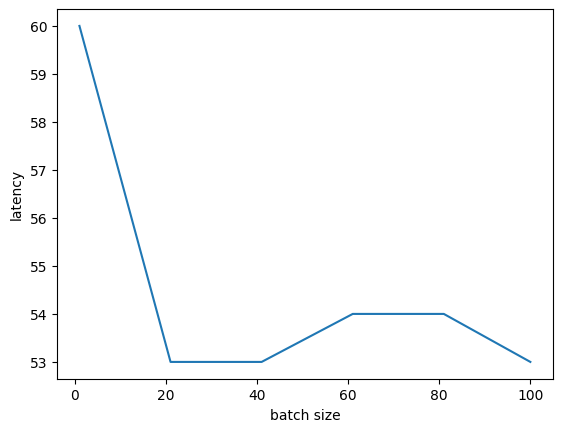

In [11]:
# visualize benchmark result
import matplotlib.pyplot as plt 

if results:
    
    batches = [int(result.batch_size) for result in results.values()]
    latencies = [result.total_time for result in results.values()]
    
    plt.plot(batches, latencies)
    
    plt.xlabel('batch size')
    plt.ylabel('latency')
    
    plt.show()
else:
    print("please wait until last step completed!")